# Import

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import zipfile

# Load Data

In [2]:
!wget --no-check-certificate \
    "https://download.pytorch.org/tutorial/hymenoptera_data.zip" \
    -O "/tmp/hymenoptera_data.zip"

zip_ref = zipfile.ZipFile("/tmp/hymenoptera_data.zip", 'r')
zip_ref.extractall("/tmp/hymenoptera")
zip_ref.close()

--2019-06-01 17:11:57--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.249.87.81, 13.249.87.90, 13.249.87.127, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.249.87.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘/tmp/hymenoptera_data.zip’

/tmp/hymenoptera_da 100%[===================>]  45.10M  69.0MB/s    in 0.7s    

2019-06-01 17:11:58 (69.0 MB/s) - ‘/tmp/hymenoptera_data.zip’ saved [47286322/47286322]



In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/tmp/hymenoptera/hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

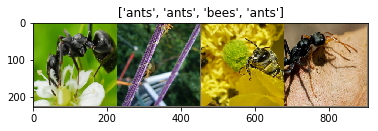

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Model Training

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Visualizing Model Predictions

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning Net

In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 23598140.16it/s]


# Training and Evaluation

In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6965 Acc: 0.6475
val Loss: 0.2253 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.5762 Acc: 0.7541
val Loss: 0.4631 Acc: 0.8170

Epoch 2/24
----------
train Loss: 0.5366 Acc: 0.7951
val Loss: 0.2308 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.4265 Acc: 0.8525
val Loss: 0.3169 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.4341 Acc: 0.8279
val Loss: 0.2657 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.3701 Acc: 0.8402
val Loss: 0.3045 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.3370 Acc: 0.8852
val Loss: 0.2059 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3148 Acc: 0.8730
val Loss: 0.1884 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3907 Acc: 0.8402
val Loss: 0.1991 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.2459 Acc: 0.8975
val Loss: 0.1930 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3133 Acc: 0.8648
val Loss: 0.2127 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2678 Acc: 0.8811
val Loss: 0.1915 Acc: 0.9216

Ep

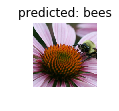

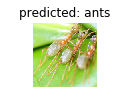

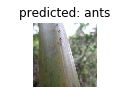

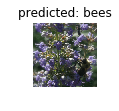

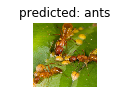

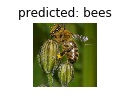

In [15]:
visualize_model(model_ft)

# Fixed Feature Extraction with ConvNet

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# Training and Evaluation

In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6474 Acc: 0.6721
val Loss: 0.3408 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.6816 Acc: 0.7090
val Loss: 0.2395 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4740 Acc: 0.7951
val Loss: 0.1633 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.5054 Acc: 0.8033
val Loss: 0.1389 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.4659 Acc: 0.7869
val Loss: 0.1308 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4830 Acc: 0.8074
val Loss: 0.1848 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.3813 Acc: 0.8279
val Loss: 0.1831 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3649 Acc: 0.8443
val Loss: 0.1659 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3223 Acc: 0.8607
val Loss: 0.1614 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3286 Acc: 0.8648
val Loss: 0.1562 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3702 Acc: 0.8689
val Loss: 0.1565 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3196 Acc: 0.8689
val Loss: 0.1611 Acc: 0.9477

Ep

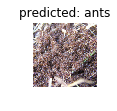

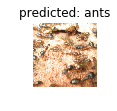

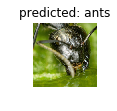

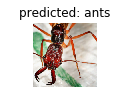

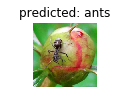

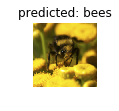

In [18]:
visualize_model(model_conv)

plt.ioff()
plt.show()